# Notebook for RDE stability analysis

Script to investigate the ECSA loss during an accelerated stress test (AST). For more information about the functions, see comments in analysis_RDE.py.

### 1. Initialization

In [1]:
%load_ext autoreload
from analysis_RDE import *
from analysis_RDE import ECSA_calculation
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os
import pandas as pd
from numpy import savetxt

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

''

### 1.1 Introducting experimental parameters.

Fill in the corresponding values.

In [2]:
A_geo = 0.196               # cm2
loading = 10                # ug/cm2
ir_comp = 30                # ohm
charge_ecsa = 0.000210      # C/cm2
Pt_mass = loading * A_geo   # mg
scan_rate = 0.05            # V/s for CO stripping

index = 10                  # number of lines of info to be removed

#### 1.2 Check the reference electrode.

Chosen file: L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/ML00/ML00_M011_Cyc0003.txt
Shift by 0.00413 V.


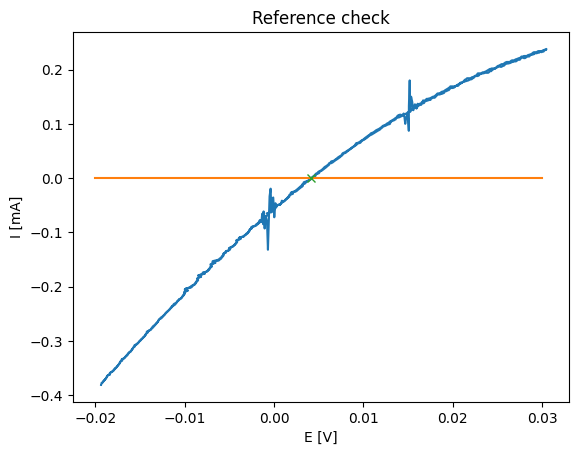

In [33]:
%autoreload
H2_file = filedialog.askopenfilename(title="Choose the file with CV under hydrogen.")
V, I = get_voltage_current(H2_file, index)
print("Chosen file:",H2_file)

x_lower_limit = -0.02
x_upper_limit = 0.03
reference = reference_check(V, I, x_lower_limit, x_upper_limit)

### 2. Choose which file(s) to analyze

#### 2.A Analysis of one file: Open the file with the interesting voltage and current data.

In [34]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename(title="Choose the file to be analyzed.")
V, I = get_voltage_current(file, index)
print(file)

L:/P15 SEM/Linnéa/2024_02_2021/Stability/ML00_M038_Cyc0002.txt


#### 2.B Analysis of several files: Open the files with the interesting voltage and current data.

In [34]:
nbr_files = 2  #not important, just not 1
files = filedialog.askopenfilenames(title="Choose the files to be analyzed.")
print(files)
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, index)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M022_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M025_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M028_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M031_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M034_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M037_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M040_Cyc0001.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M043_Cyc0001.txt')


### 3. Introduce background: choose the corresponding file(s)

In [35]:
%autoreload
if nbr_files == 1:
    background_file = filedialog.askopenfilename(title="Choose the background file.")
    print(background_file)
    background_V, background_I = get_background(background_file, index)
else:
    background_files = filedialog.askopenfilenames(title="Choose the background files.")
    print(background_files)
    background_matrix = []
    for i, background_file in enumerate(background_files): 
        V_i, I_i = get_background(background_file, index)
        background_matrix.append(V_i)
        background_matrix.append(I_i)

    background_matrix = np.transpose(background_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M022_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M025_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M028_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M031_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M034_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M037_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M040_Cyc0002.txt', 'L:/P15 SEM/Linnéa/2024_06_0506/2024_06_05/Stability/ML01_M043_Cyc0002.txt')


### 4. Corrections
The following corrections can be made:
* Adjusting voltage to RHE potential.
* Background adjustment of current.
* iR-drop correction (usually done directly in Labview)

In [36]:
%autoreload
if nbr_files == 1:
    background_V_RHE = copy.deepcopy(background_V)
    background_I_RHE = copy.deepcopy(background_I)
    V_RHE = copy.deepcopy(V)
    I_corrected = copy.deepcopy(I)

    background_V_RHE = RHE_correction(background_V_RHE, reference)
    V_RHE = RHE_correction(V_RHE, reference)
    I_corrected = background_correction_current(I_corrected, background_I_RHE)   
else:
    background_RHE = copy.deepcopy(background_matrix)
    background_RHE = RHE_correction_background(background_RHE, reference)
    data_RHE = copy.deepcopy(data_matrix)
    corrected_data_RHE = copy.deepcopy(data_matrix)
    
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:      #voltage are stored in even indexed columns
            data_RHE[:,i] = RHE_correction(data_RHE[:,i], reference)
            corrected_data_RHE[:,i] = RHE_correction(corrected_data_RHE[:,i], reference)
        else:               #current
            corrected_data_RHE[:,i] = background_correction_current(corrected_data_RHE[:,i], background_RHE[:,i])

### 5. Normalizing to geometric surface area and mass

In [37]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I_corrected)
    surface_I = copy.deepcopy(I_corrected)

    mass_I, surface_I = normalizing(mass_I, loading, A_geo)
else:
    mass_matrix = copy.deepcopy(corrected_data_RHE)
    surface_matrix = copy.deepcopy(corrected_data_RHE) 

    for i in range(1, len(data_matrix[0]), 2):   #only looping the current columns
        mass_matrix[:,i], surface_matrix[:,i] = normalizing(mass_matrix[:,i], loading, A_geo)
    

### 6. Plotting

Text(0.5, 1.0, 'CO stripping minus CV')

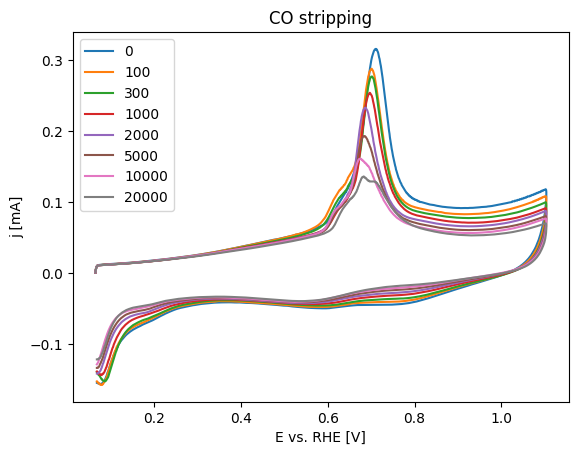

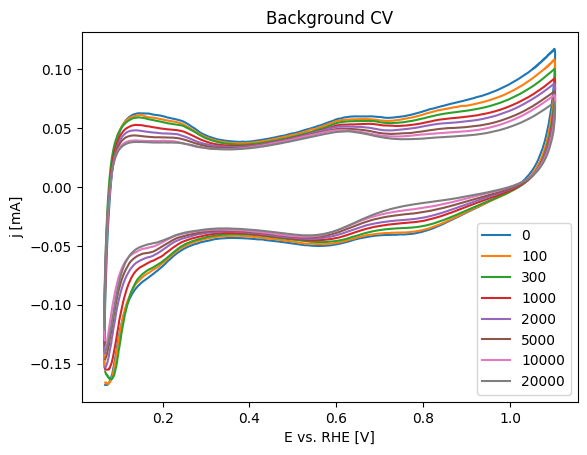

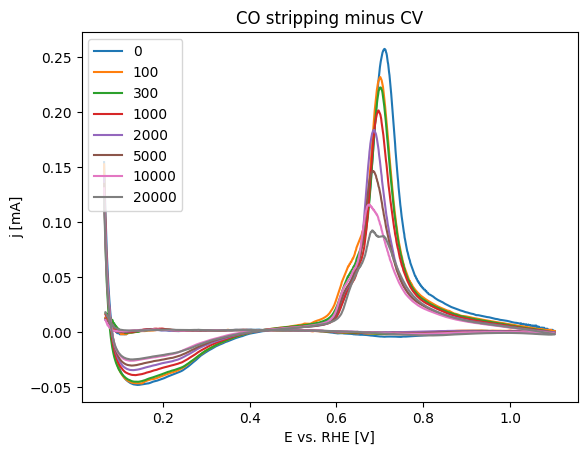

In [38]:
# Adapt to makrolist
cycles = ['0', '100', '300', '1000', '2000', '5000','10000', '20000']  

fig1, ax1 = plt.subplots()
for i in range(0,len(data_RHE[0]),2):
    ax1.plot(data_RHE[:,i], data_RHE[:,i+1])
ax1.legend(cycles, loc='upper left')  
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('j [mA]')
ax1.set_title("CO stripping")

# Uncomment to get both background and CO in same plot
fig2, ax2 = plt.subplots()
for i in range(0,len(background_RHE[0]),2):
    ax2.plot(background_RHE[:,i], background_RHE[:,i+1])
    #ax2.plot(data_RHE[:,i], data_RHE[:,i+1])
ax2.legend(cycles)
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('j [mA]')
#ax2.set_title('CO stripping and CV')
ax2.set_title("Background CV")

fig3, ax3 = plt.subplots()
for i in range(0,len(corrected_data_RHE[0]),2):
    ax3.plot(corrected_data_RHE[:,i], corrected_data_RHE[:,i+1])
ax3.legend(cycles, loc='upper left')
ax3.set_xlabel('E vs. RHE [V]')
ax3.set_ylabel('j [mA]')
ax3.set_title("CO stripping minus CV")

### 7. Analysis
Determining ECSA etc.

In [39]:
%autoreload
lower_voltage = 0.06
upper_voltage = 1.0
# The following values need to be tuned
DL_start = 0.48   #determines the starting point for your baseline  
DL_end = 0.52     #determines the end point for your baseline
atol = 0.4        #determines the threshold where the CO peak deviates too much from baseline 

ECSAs = []
specific_ECSAs = []
for i in range(0, len(data_RHE[0])-1, 2):
    ecsa_calculation = ECSA_calculation(data_RHE[:,i], data_RHE[:,i+1], background_RHE[:,i], background_RHE[:,i+1])

    specific_ECSA, ECSA = ecsa_calculation.calculating_ECSA(
        lower_voltage,
        upper_voltage,
        DL_start,
        DL_end,
        atol,
        scan_rate,
        charge_ecsa,
        Pt_mass,
    )

    specific_ECSAs.append(specific_ECSA)
    ECSAs.append(ECSA)
#ecsa_calculation.plotting()

Specific ECSA CO str: 46.98900038020004 m2/g(Pt) 	ECSA CO str: 0.9209844074519208 cm2 
Specific ECSA HUPD:   45.51308921731403 m2/g(Pt) 	ECSA HUPD: 0.892056548659355 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 42.62039083500972 m2/g(Pt) 	ECSA CO str: 0.8353596603661906 cm2 
Specific ECSA HUPD:   41.537332272255966 m2/g(Pt) 	ECSA HUPD: 0.814131712536217 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 39.30005711750603 m2/g(Pt) 	ECSA CO str: 0.7702811195031181 cm2 
Specific ECSA HUPD:   42.584388289335635 m2/g(Pt) 	ECSA HUPD: 0.8346540104709784 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 35.29076959852636 m2/g(Pt) 	ECSA CO str: 0.6916990841311167 cm2 
Specific ECSA HUPD:   36.42654449779118 m2/g(Pt) 	ECSA HUPD: 0.7139602721567071 cm2
	-------------------------------------------------------------------
Specific ECSA CO str: 31.097939979287602

Check that the inputted values align well with the curves.

Specific ECSA CO str: 46.98900038020004 m2/g(Pt) 	ECSA CO str: 0.9209844074519208 cm2 
Specific ECSA HUPD:   45.51308921731403 m2/g(Pt) 	ECSA HUPD: 0.892056548659355 cm2
	-------------------------------------------------------------------


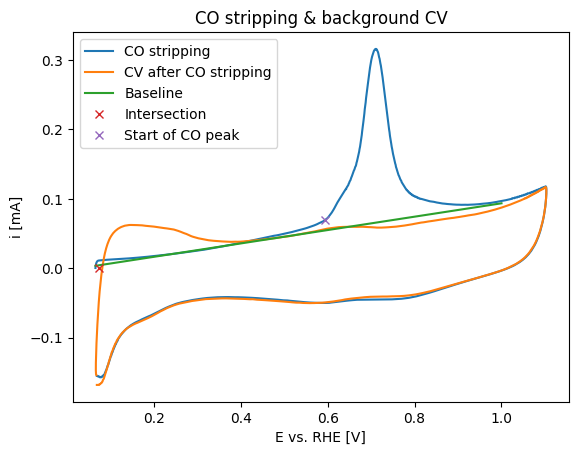

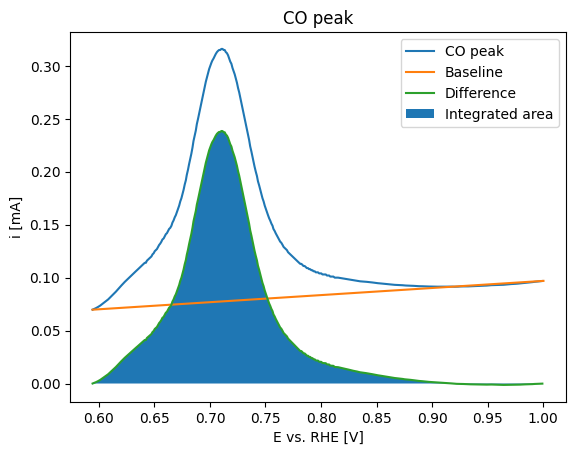

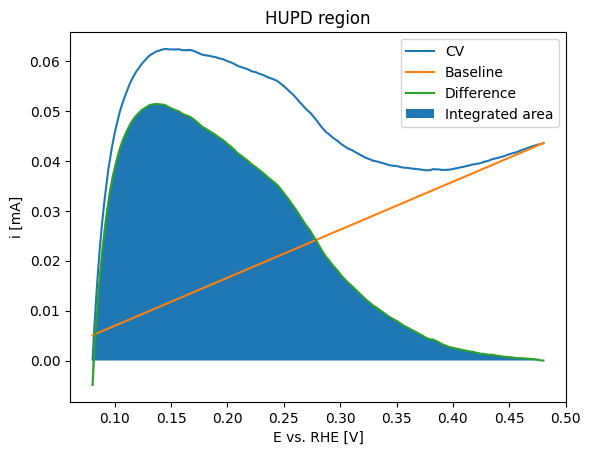

In [40]:
%autoreload
lower_voltage = 0.06
upper_voltage = 1.0
DL_start = 0.48   
DL_end = 0.52
tolerence = 0.4

# Check some V-I couples in data_matrix
V_index = 0
I_index = 1
ecsa_calculation = ECSA_calculation(data_RHE[:,V_index], data_RHE[:,I_index], background_RHE[:,V_index], background_RHE[:,I_index])

specific_ECSA, ECSA = ecsa_calculation.calculating_ECSA(
    lower_voltage,
    upper_voltage,
    DL_start,
    DL_end,
    tolerence,
    scan_rate,
    charge_ecsa,
    Pt_mass,
)
ecsa_calculation.plotting()

##### Plotting the decrease.

[100.0, 90.70291023464475, 83.63671667734832, 75.1043208261076, 66.18131845254464, 56.49296547612577, 46.61164813193119, 40.0616241434117]


C:\Users\go29guw\AppData\Local\Temp\ipykernel_15144\1594818421.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,100000])


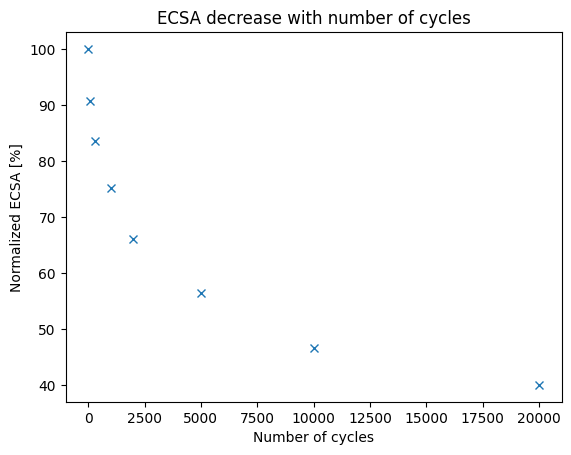

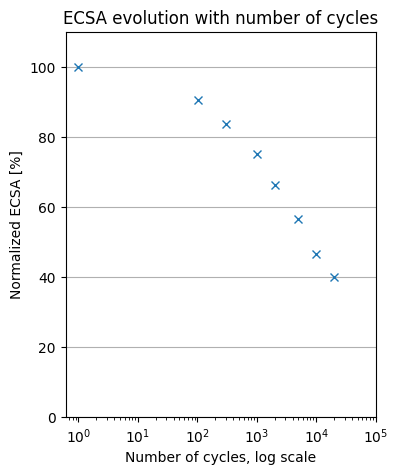

In [41]:
cycles_int = list(map(int, cycles))
CO_areas = [row[0] for row in specific_ECSAs]
normalized_areas = [100*i/CO_areas[0] for i in CO_areas]
print(normalized_areas)

fig1, ax1 = plt.subplots()
ax1.plot(cycles_int, normalized_areas, 'x')
ax1.set_xlabel("Number of cycles")
ax1.set_ylabel("Normalized ECSA [%]")
ax1.set_title("ECSA decrease with number of cycles")

fig2 = plt.figure(figsize=(4,5))
plt.plot([i+1 for i in cycles_int], normalized_areas, 'x')
plt.semilogx()
plt.ylim([0,110])
plt.xlim([0,100000])
plt.xlabel("Number of cycles, log scale")
plt.ylabel("Normalized ECSA [%]")
plt.title("ECSA evolution with number of cycles")
plt.grid(axis='y')

Export data.

In [42]:
# First argument determines the name of the file to be saved, 
# second is the data (numpy array) you want to save.
np.savetxt('stability_data_0506', normalized_areas, delimiter=",")

#### Analyse data from several measurements.
Import the files that you created in the previous step that you now want to compare. Important to change the name of the file the data is stored in (i.e. stab1) so that you don't overwrite your already imported data.

In [64]:
with open("stability_data_1819", 'r') as file:
    stab1 = file.readlines()
    i = 0
    for elm in stab1:  
        new_elm = elm.rstrip("\n")
        stab1[i] = float(new_elm)
        i += 1

In [73]:
# Put together all the files you want to analyse
stabilities = np.transpose([stab1, stab2, stab3])
n = 3   #change depending on how many measurements you're analysing

averages = []
stdvs = []
for row in stabilities:
    average_elm = np.average(row)
    stdv_elm = np.std(row)
    averages.append(average_elm)
    stdvs.append(stdv_elm)

errors = [i/np.sqrt(n) for i in stdvs]

Plotting.

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\go29guw\AppData\Local\Temp\ipykernel_15144\3838345392.py:7: SyntaxWarning: invalid escape sequence '\d'
  plt.plot([i+1 for i in cycles_int], averages, linestyle='dashed', color='mediumpurple', label='Pt/C, I/C=0.7, 60$\degree$ C')
C:\Users\go29guw\AppData\Local\Temp\ipykernel_15144\3838345392.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,100000])


Text(0, 0.5, 'Retained ECSA [%]')

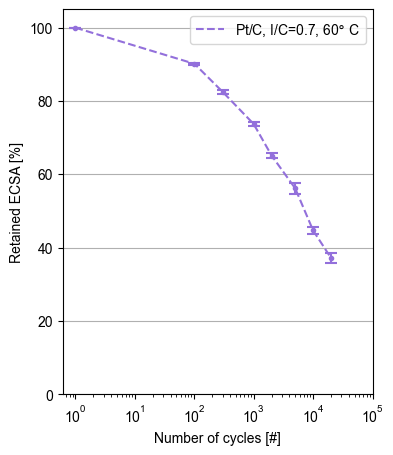

In [75]:
cycles_int = [0, 100, 300, 1000, 2000, 5000, 10000, 20000]

plt.rcParams["font.family"] = "Arial"
fig = plt.figure(figsize=(4,5))
ax = plt.subplot()
plt.plot([i+1 for i in cycles_int], averages, linestyle='dashed', color='mediumpurple', label='Pt/C, I/C=0.7, 60$\degree$ C')
plt.errorbar([i+1 for i in cycles_int], averages, yerr=errors, fmt='.', capsize=4, capthick=1.5, color='mediumpurple')
plt.grid(axis='y')
plt.semilogx()
plt.ylim([0,105])
ax.set_yticks(ticks=np.arange(0, 101, 20))
plt.xlim([0,100000])
plt.legend()
plt.xlabel("Number of cycles [#]")
plt.ylabel("Retained ECSA [%]")